In [35]:
import pickle
import os

In [36]:
with open('dic.pkl', 'rb') as f:
    dic = pickle.load(f)

In [59]:
lst = os.listdir('CompanyData')
orig = list(dic.keys())
chosen_list = []
delete_list = ['FALC', 'IDT', 'PRCP', 'BBOX', 'EVOL', 'CTS', 'FDC', 'NIHD', 'BRKS', 'KODK', 'OSPN', 'AEIS', 'LGL', 'QADA', 'PCMI', 'INVE', 'ZOOM', 'CACI']
for k in orig:
    if k in delete_list:
        pass
    else:
        chosen_list.append(k)
print(chosen_list)
with open('chosen_list.txt', 'w') as f:
    for item in chosen_list:
        f.write("%s\n" % item)
chosen_list = chosen_list[:-2]
n_of_comp = len(chosen_list)
n_of_comp

['PEGA', 'CASS', 'COHU', 'BDR', 'HMNY', 'BELFB', 'CDNS', 'KLAC', 'CY', 'XLNX', 'TACT', 'WGNR', 'NVDA', 'CMTL', 'AXE', 'TTWO', 'IT', 'INTC', 'ANEN', 'AMSWA', 'SYMC', 'AMKR', 'SPDC', 'CSCO', 'TLAB', 'SHEN', 'XRX', 'BHE', 'INTT', 'INAP', 'FTR', 'CRAY', 'SMIT', 'GVP', 'OLED', 'CYBE', 'MTSC', 'MCHP', 'ESCC', 'CTL', 'APH', 'LFUS', 'RMTR', 'VSAT', 'LSCC', 'ON', 'TDS', 'PAR', 'AAPL', 'PAYX', 'AXTI', 'EGOV', 'MMS', 'CELL', 'INTU', 'MSI', 'TRT', 'MSFT', 'QUIK', 'INOD', 'DGII', 'CSGS', 'DAIO', 'DDD', 'ASYS', 'WTT', 'EA', 'ITI', 'STCN', 'DIOD', 'NSYS', 'PLT', 'CYMI', 'MU', 'ZIXI', 'KVHI', 'NWK', 'DRCO', 'FICO', 'MSTR', 'IBM', 'CSPI', 'FSII', 'TYL', 'TXN', 'ADBE', 'HLIT', 'ALOT', 'CBB', 'PKE', 'SUPX', 'ADI', 'FARO', 'FFIV', 'EEFT', 'FLEX', 'VECO', 'MKSI', 'AWRE', 'FLIR', 'IAC', 'TSS', 'CIEN', 'TESS', 'MXWL', 'PRST', 'EBIX', 'IEC', 'VSH', 'ASUR', 'ZBRA', 'PCTI', 'TER', 'ANSS', 'TCX', 'EGHT', 'AMD', 'ACCL', 'WDC', 'OSIS', 'CREE', 'PFSW', 'ATEA', 'KLIC', 'NCR', 'CNXN', 'AVX', 'FEIM', 'ATNI', 'TRMB', '

130

In [52]:
print(len(dic['AAPL']['LAR']))

30


In [37]:
import numpy as np
def get_data(st, ed):
    X, Y = [], []
    for comp in chosen_list[st : ed]:
        for i in range(len(dic[comp]['sentiment_list']) - 1):
            X.append(list(dic[comp]['sentiment_list'][i]))
            #print(dic[comp]['LAR'][i])
            X[-1].append(dic[comp]['LAR'][i])
            #X[-1] = np.array(X[-1])
            Y.append([dic[comp]['return_rate'][i]])
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [60]:
from sklearn.linear_model import Ridge, LinearRegression
def train_linear_regression(X, Y, Xall, Yall):
    X = (X - np.mean(Xall, axis = 0)) / np.std(Xall, axis = 0)
    clf = Ridge(alpha = 0.1)
    clf.fit(X, Y)
    #print('training:')
    #print('L2 error:\t', np.sum((clf.predict(X) - Y) ** 2) / Y.shape[0])
    #print('score:\t', clf.score(X, Y))
    #print('validation:')
    #print('L2 error:\t', np.sum((clf.predict(Xval) - Yval) ** 2) / Yval.shape[0])
    #print('score:\t', clf.score(Xval, Yval))
    r = np.corrcoef(clf.predict(X).reshape(-1), Y.reshape(-1))
    rall = np.corrcoef(clf.predict(Xall).reshape(-1), Yall.reshape(-1))
    #print('\nCorrelated Coefficient:\n', r[0][1], rall[0][1])
    pred = []
    lenx = Xall.shape[0]
    for i in range(n_of_comp):
        Xind = (Xall[lenx //  n_of_comp * i: lenx // n_of_comp * (i + 1)] - np.mean(Xall, axis = 0)) / np.std(Xall, axis = 0)
        pred.append(clf.predict(Xind).reshape(-1))
    pred = np.array(pred)
    return clf.coef_, np.array(pred)

In [48]:
import numpy as np
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
def train_dnn(X, Y, Xall, Yall):
    X = (X - np.mean(Xall, axis = 0)) / np.std(Xall, axis = 0)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    model = Sequential()
    model.add(Dense(128, input_shape = (X.shape[1], 1)))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = Adam(), metrics = [])
    model.fit(X, Y, batch_size = 32, epochs = 20)
    pred = []
    for i in range(n_of_comp):
        Xind = (Xall[lenx //  n_of_comp * i: lenx // n_of_comp * (i + 1)] - np.mean(Xall, axis = 0)) / np.std(Xall, axis = 0)
        tmp = model.predict(Xind.reshape((Xind.shape[0], Xind.shape[1], 1))).reshape(-1)
        pred.append(tmp)
    return np.array(pred)

In [69]:
Xall, Yall = get_data(0, n_of_comp)
lenx = Xall.shape[0]
K = 15
pred = np.zeros((n_of_comp, 29))
coef = np.zeros((1, 9))
for i in range(K):
    X, Y = get_data(n_of_comp // K * i, n_of_comp // K * (i + 1))
    c, p = train_linear_regression(X, Y, Xall, Yall)
    pred += p
    coef += c
pred /= K
coef /= K
print(coef)
r = [np.corrcoef(pred[i], Yall[lenx // n_of_comp * i: lenx // n_of_comp * (i + 1)].reshape(-1))[0][1] for i in range(n_of_comp)]
companies = list(dic.keys())
rank = [(r[i], companies[i]) for i in range(n_of_comp)]
rank = sorted(rank, reverse = True)
print(np.mean(np.array(r), axis = None))
rank

[[ 1.36022737e-04 -2.88079583e-05 -1.79988438e-04 -1.25449833e-04
  -6.80275697e-05 -2.26681534e-04 -3.68875393e-05 -3.84244921e-05
   1.79663135e-04]]
0.09214236628201361


[(0.6477577926426054, 'KVHI'),
 (0.5118502744052373, 'FARO'),
 (0.4893012033946339, 'IT'),
 (0.4738723409498585, 'KLAC'),
 (0.4679024407061898, 'MU'),
 (0.46787843359069864, 'MXWL'),
 (0.40898265573008613, 'AMSWA'),
 (0.3767818456873535, 'ANSS'),
 (0.3747916349380907, 'ASUR'),
 (0.35961528816641675, 'CBB'),
 (0.3502032852787901, 'OLED'),
 (0.34695944121394556, 'APH'),
 (0.3449460030658049, 'ON'),
 (0.34455032920059997, 'MSI'),
 (0.3311018632916062, 'AMD'),
 (0.31725018029169344, 'HMNY'),
 (0.3066730468689838, 'IAC'),
 (0.30342127012369147, 'FICO'),
 (0.3018771453121539, 'SUPX'),
 (0.29697210626308795, 'ALOT'),
 (0.29435525010981006, 'BELFB'),
 (0.28750285406418574, 'HLIT'),
 (0.2794735661218102, 'INTT'),
 (0.27830141453412055, 'AMKR'),
 (0.27452193891623355, 'LSCC'),
 (0.2722633933854847, 'PEGA'),
 (0.2670199636519549, 'SHEN'),
 (0.2632446514415933, 'ADBE'),
 (0.2623027210622216, 'TXN'),
 (0.2545566812587478, 'MCHP'),
 (0.2437744108082668, 'MKSI'),
 (0.2340646404910954, 'AAPL'),
 (0.23

(29,) (29,)
[ 0.00350502  0.00626423  0.00229886  0.00411485  0.0025358   0.00648556
  0.00063377 -0.00304608  0.00097146  0.00674944 -0.00044346 -0.00025961
  0.0007931  -0.00044673  0.00021591  0.00042771 -0.00061471 -0.00106058
 -0.00260742 -0.00163162  0.00149599 -0.00184949 -0.00367856 -0.00264184
 -0.00068736  0.00122591  0.00064905  0.00429821 -0.00108959]


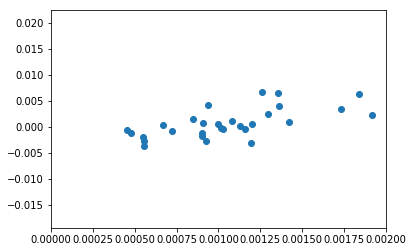

In [72]:
from matplotlib import pyplot as plt
idx = 77
X = pred[idx]
Y = Yall[29 * idx: 29 * (idx + 1)].reshape(-1)
print(X.shape, Y.shape)
print(Y)
plt.scatter(X, Y)
plt.xlim(0, 0.002)
plt.show()

In [76]:
r = np.load('rnn_r2.npy')
companies = list(dic.keys())
rank = [(r[i], companies[i]) for i in range(n_of_comp)]
rank = sorted(rank, reverse = True)
print(np.mean(r, axis = None))
rank

0.14017309630198257


[(0.7740984355711742, 'ZIXI'),
 (0.6003534964626113, 'BDR'),
 (0.5005233885598643, 'CRAY'),
 (0.48618814130389726, 'TCX'),
 (0.4701409244712629, 'CSPI'),
 (0.453471354858061, 'AXTI'),
 (0.427691622451155, 'DAIO'),
 (0.4053843781576683, 'OSIS'),
 (0.3927379786221281, 'VSAT'),
 (0.3877553514845178, 'ZBRA'),
 (0.38254135643364046, 'NCR'),
 (0.3807212868891, 'ALOT'),
 (0.3555409749159538, 'KLIC'),
 (0.3504316657453872, 'CELL'),
 (0.34920725629841354, 'AWRE'),
 (0.3482113433396488, 'XLNX'),
 (0.3398447140780127, 'APH'),
 (0.33869048143859465, 'TER'),
 (0.3350990140696757, 'CACI'),
 (0.3277562620562466, 'ITI'),
 (0.32742594534492486, 'PCTI'),
 (0.32362858055440735, 'INAP'),
 (0.3139827397344916, 'NSYS'),
 (0.3134904616735456, 'QUIK'),
 (0.3057480357744618, 'FSII'),
 (0.3038052643301045, 'EGOV'),
 (0.27821815240121206, 'TYL'),
 (0.2748016193502697, 'ON'),
 (0.2721328537522105, 'GVP'),
 (0.26554130574652995, 'AMSWA'),
 (0.2624942596929694, 'MSFT'),
 (0.2617035570280507, 'EEFT'),
 (0.2612213419

In [79]:
for idx, i in enumerate(dic):
    if i == 'BDR':
        print(idx)
        break

4


(29,) (29,)
[-0.00187578  0.00112957 -0.00108627 -0.00152981  0.00547754  0.00814817
  0.01983186  0.00343789  0.00904961 -0.00013839  0.02682201 -0.00017811
 -0.00052995  0.00062291  0.00344295 -0.00669658 -0.00060398  0.00272898
 -0.00101358 -0.00450143  0.00095613  0.00175272 -0.00048158 -0.00294165
  0.00513667  0.01168248 -0.00568111 -0.00259589  0.02084343]


<module 'matplotlib.pyplot' from '/Users/howard/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

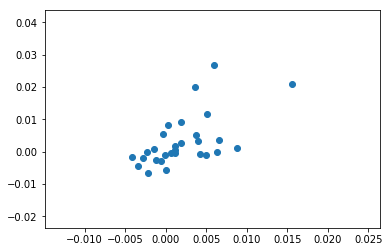

In [80]:
from matplotlib import pyplot as plt
idx = 4
X = np.load('rnn_pred2.npy')
X = X[idx]
Xall, Yall = get_data(0, n_of_comp)
Y = Yall[29 * idx: 29 * (idx + 1)].reshape(-1)
print(X.shape, Y.shape)
print(Y)
plt.scatter(X, Y)
plt

In [82]:
print(dic['AAPL']['msci'])

KeyError: 'msci'